<a href="https://colab.research.google.com/github/LIKITH43/Rice-type-classification/blob/main/Rice_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [3]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv") # Read the data
data_df.dropna(inplace = True) # Drop missing/null values
data_df.drop(["id"], axis =1, inplace = True) # Drop Id column
print("Output possibilities: ", data_df["Class"].unique()) # Possible Outputs
print("Data Shape (rows, cols): ", data_df.shape) # Print data shape
data_df.head() # Print/visualize the first 5 rows of the data

Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
original_df = data_df.copy() # Creating a copy of the original Dataframe to use to normalize inference

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max() # Divide by the maximum of the column which will make max value of each column is 1
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [6]:
X = np.array(data_df.iloc[:,:-1]) # Get the inputs, all rows and all columns except last column (output)
Y = np.array(data_df.iloc[:, -1]) # Get the ouputs, all rows and last column only (output column)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3) # Create the training split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) # Create the validation split

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape

Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


In [7]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [8]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [9]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [10]:
class MyModel(nn.Module):
    def __init__(self):

        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [11]:
model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [12]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= LR)

In [13]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2487 Train Accuracy: 75.3084 Validation Loss: 0.0415 Validation Accuracy: 97.4340
Epoch no. 2 Train Loss: 0.1290 Train Accuracy: 98.1774 Validation Loss: 0.0168 Validation Accuracy: 98.2771
Epoch no. 3 Train Loss: 0.0576 Train Accuracy: 98.4366 Validation Loss: 0.0090 Validation Accuracy: 98.5704
Epoch no. 4 Train Loss: 0.0357 Train Accuracy: 98.5466 Validation Loss: 0.0064 Validation Accuracy: 98.4971
Epoch no. 5 Train Loss: 0.0273 Train Accuracy: 98.6252 Validation Loss: 0.0052 Validation Accuracy: 98.4971
Epoch no. 6 Train Loss: 0.0232 Train Accuracy: 98.5545 Validation Loss: 0.0046 Validation Accuracy: 98.4971
Epoch no. 7 Train Loss: 0.0208 Train Accuracy: 98.6566 Validation Loss: 0.0045 Validation Accuracy: 98.6437
Epoch no. 8 Train Loss: 0.0193 Train Accuracy: 98.6252 Validation Loss: 0.0042 Validation Accuracy: 98.6070
Epoch no. 9 Train Loss: 0.0184 Train Accuracy: 98.6016 Validation Loss: 0.0040 Validation Accuracy: 98.7170
Epoch no. 10 Train Loss: 0.0

In [14]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.53%


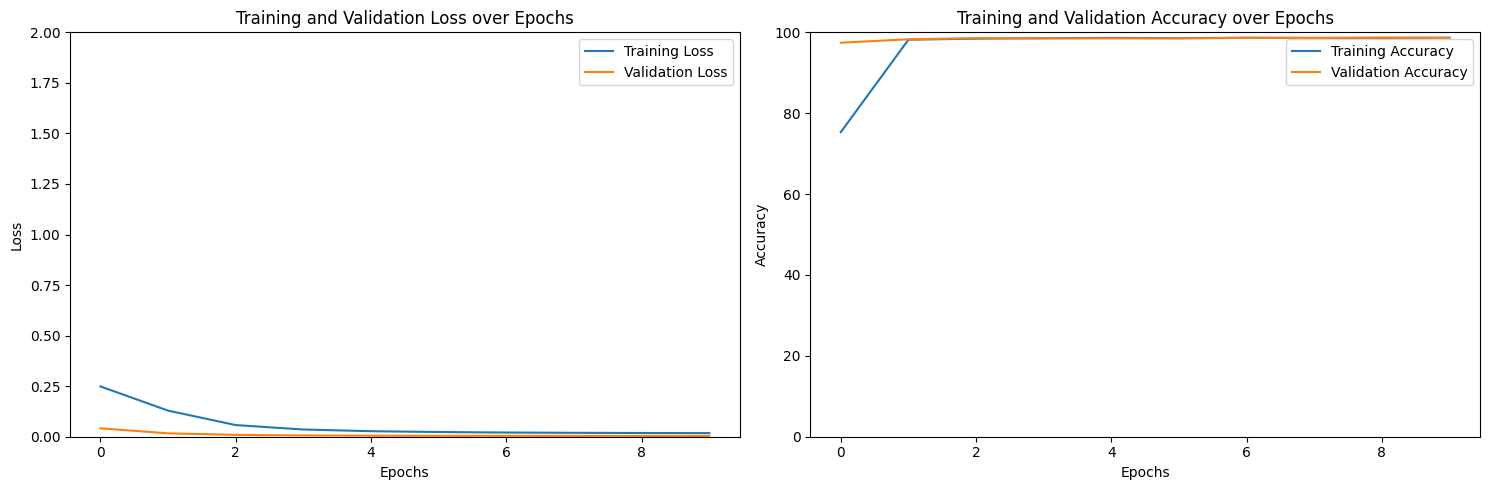

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss') #Kanumuri
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [16]:
area = float(input("Area: "))/original_df['Area'].abs().max()
#BY_LIKITH
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 6431.279
Major Axis Length: 145.21338
Minor Axis Length: 56.902
Eccentricity: 0.919981821
Convex Area: 6518.93759999
EquivDiameter: 90.483541
Extent: 0.8506668
Perimeter: 329.972
Roundness: 0.742255516
AspectRation: 2.551696
tensor([0.7495], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  1
